**Курсовой проект по курсу**

**"Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"**

kaggle:


Sumarokov Yuriy (https://www.kaggle.com/vokoramus)


#### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Функции

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    # plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    # plt.show()


def evaluate_preds1(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    # plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
 
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    # plt.show()

#### Пути к директориям и файлам

In [4]:
PATH = 'drive/MyDrive/ML/course_project/'
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'
SUBMITION_DATASET = 'sample_submission.csv'


TRAIN_DATASET_PATH = PATH + TRAIN_DATASET 
TEST_DATASET_PATH = PATH + TEST_DATASET
SUBMITION_MY = PATH + 'submission_4.csv'

#### Подключаю G-Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Загрузка данных

#### train

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [9]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


#### test

In [10]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [11]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


#### Деление признаков на текстовые и числовые

In [12]:
num_feat = list(train_df.select_dtypes(exclude='object').columns)
obj_feat = list(train_df.select_dtypes(include='object').columns)
target = 'Price'

num_feat

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

##### **Приведение типов**

In [13]:
train_df['Id'] = train_df['Id'].astype(str)

##### **Поиск выбросов**

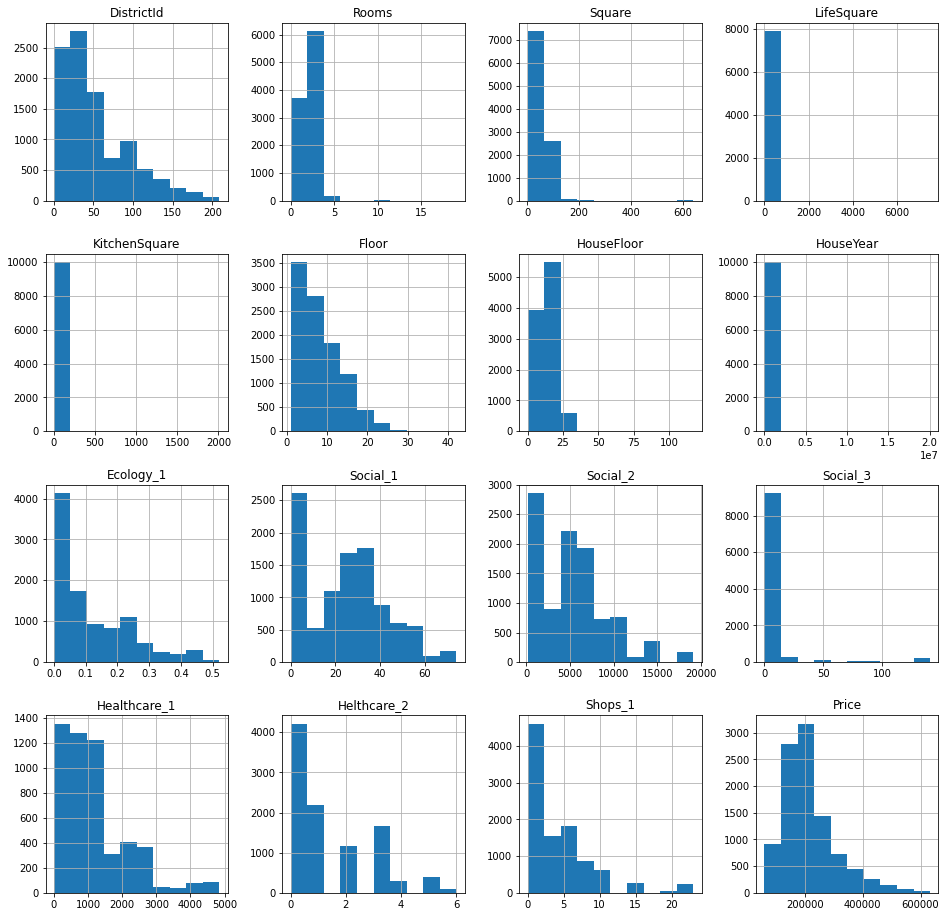

In [14]:
train_df[num_feat].hist(figsize=(16,16))
plt.show()

In [15]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839522,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776200,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


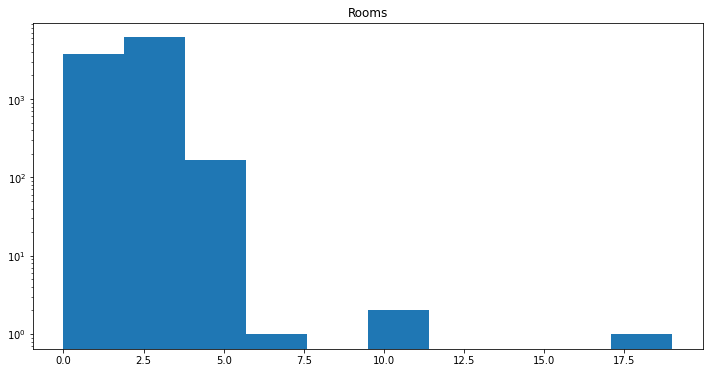

In [16]:
plt.figure(figsize=(12,6))
plt.hist(train_df['Rooms'], log=True)
plt.title('Rooms')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


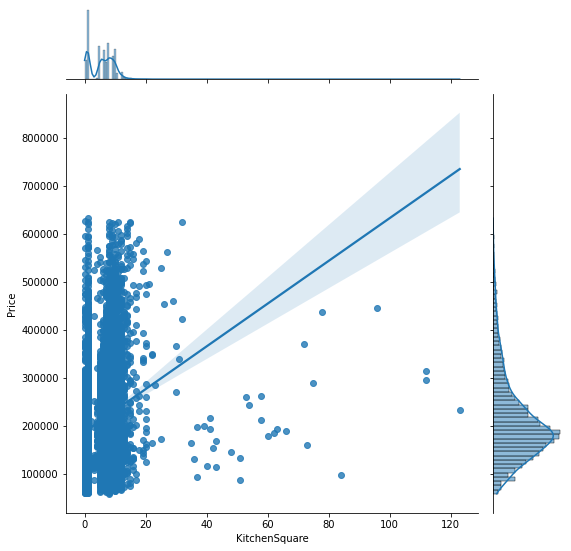

In [17]:
train_df_temp = train_df.loc[train_df['KitchenSquare'] < 250]
grid = sns.jointplot(train_df_temp['KitchenSquare'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


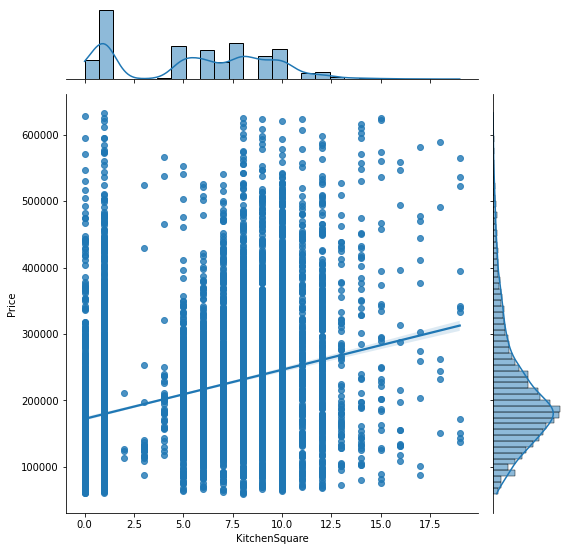

In [18]:
train_df_temp = train_df.loc[train_df['KitchenSquare'] < 20]
grid = sns.jointplot(train_df_temp['KitchenSquare'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

#### Анализ целевой переменной Price

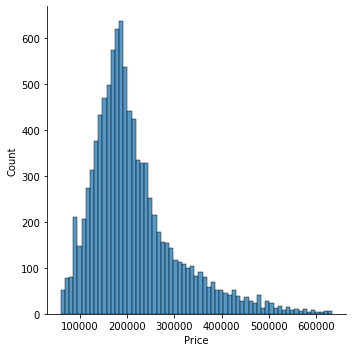

In [19]:
sns.displot(train_df['Price'])
plt.show()

# Classes

#### Класс DataPreprocessing 

In [20]:
class DataPreprocessing:
    """Подготовка исходных данных"""    

    def __init__(self):
        """Параметры класса"""

        self.Square_min = 15
        self.Square_max = 300
        
        self.LifeSquare_min = 10
        self.LifeSquare_max = 280
        
        self.Rooms_min = 1
        self.Rooms_max = 5
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.current_year = datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, train_df):
        """Сохранение статистик"""     

        # медианы
        self.medians = train_df[['LifeSquare', 'HouseFloor']].median()

            # Вспомогательный df_Rooms_medians
        self.df_Squares = train_df.loc[~train_df['LifeSquare'].isna()]
            # Найдем медианы Square или LifeSquare в зав-ти от числа комнат
        self.df_Rooms_medians = self.df_Squares.groupby('Rooms').agg({
            'Square': 'median',
            'LifeSquare': 'median',
            })

        self.df_Rooms_medians = self.df_Rooms_medians.rename(columns={'Square': 'Square_med', 
                                                            'LifeSquare': 'LifeSquare_med'})
        self.df_Rooms_medians.reset_index(inplace=True)


    def transform(self, X):
        """Трансформация данных"""

        # Обработка пропусков
        X[['LifeSquare', 'HouseFloor']] = X[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        


        # Обработка выбросов
        
        # Square
        X.loc[(X['Square'] > self.Square_max), 'Square'] = self.Square_max
        X.loc[(X['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # LifeSquare
        X.loc[(X['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        X.loc[(X['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # KitchenSquare
        X.loc[(X['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        X.loc[(X['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # HouseYear
        X.loc[(X['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # Rooms
        X.loc[(X['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        X.loc[(X['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        #HouseFloor
        X.loc[(X['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        X.loc[(X['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # если этаж больше этажности дома, то присваиваем случайный этаж от self.HouseFloor_min до максимального этажа в доме
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'] \
              .apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
        
        # Обработка категорий
        X = pd.concat([X, pd.get_dummies(X['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        X = pd.concat([X, pd.get_dummies(X['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        X = pd.concat([X, pd.get_dummies(X['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
 
        # ========================================================
        # Обработка выбросов Square, LifeSquare, KitchenSquare (Совместно)

        X = pd.merge(X, self.df_Rooms_medians, on='Rooms', how='left')

        # Отношение жилой площади к общей площади
        X['LifeSquare_ratio'] = X['LifeSquare'] / X['Square']

        X['Square_diff'] = abs(X['Square'] - X['Square_med']) # новые столбцы (отклонения от медиан)
        X['LifeSquare_diff'] = abs(X['LifeSquare'] - X['LifeSquare_med']) # новые столбцы (отклонения от медиан)

        # если LifeSquare_ratio > 3, то предполагаю, что выброс в одном из значений: Square или LifeSquare 
        X.loc[(X['LifeSquare_ratio'] > 3) & 
                  (X['Square_diff'] >= X['LifeSquare_diff']),
                  'Square'
                  ] = X['Square_med']

        X.loc[(X['LifeSquare_ratio'] > 3) & 
                  (X['Square_diff'] < X['LifeSquare_diff']),
                  'LifeSquare'
                  ] = X['LifeSquare_med']

        X['LifeSquare_ratio'] = X['LifeSquare'] / X['Square']  # Пересчет LifeSquare_ratio после замены

        # если LifeSquare_ratio между 1 и 3, то предполагаю, что Square и LifeSquare перепутаны местами
        X.loc[X['LifeSquare_ratio'].between(1, 3), 'Square'], X.loc[X['LifeSquare_ratio'].between(1, 3), 'LifeSquare'] = \
        X.loc[X['LifeSquare_ratio'].between(1, 3), 'LifeSquare'], X.loc[X['LifeSquare_ratio'].between(1, 3), 'Square']

        X['LifeSquare_ratio'] = X['LifeSquare'] / X['Square']  # Пересчет LifeSquare_ratio после перестановки

        return X

#### Class FeatureGenerator

In [21]:
class FeatureGenerator():
    """Генерация новых фич"""

    def __init__(self):

        self.Square_min = 15
        self.Square_max = 300
        self.SquareMeterPrice_by_DistrictId = None

    def fit(self, X):
        
        # подсчет средней цены за м2 по району
        df_temp = X.loc[(X['Square'] > self.Square_min) & (X['Square'] < self.Square_max)]
        df_temp["SquareMeterPrice"] = df_temp["Price"] / df_temp["Square"]

        self.av_price_df = df_temp.copy()

        self.SquareMeterPrice_by_DistrictId = df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})


    def transform(self, X):
        # средняя стоимость м2 по району
        X = X.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        X['AverageSquareMeterPrice'].fillna(X['AverageSquareMeterPrice'].median(), inplace=True)        


        return X

### Разбиение на train и valid

In [22]:
X = train_df
y = train_df['Price']
X_test = test_df

In [23]:
X.shape, y.shape, X_test.shape

((10000, 20), (10000,), (5000, 19))

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [25]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((7000, 20), (3000, 20), (7000,), (3000,))

Преобразования данных

In [26]:
data_inst = DataPreprocessing()

# train
data_inst.fit(X_train)
X_train = data_inst.transform(X_train)

# valid
X_valid = data_inst.transform(X_valid)

# test
X_test = data_inst.transform(X_test)

In [27]:
feature_gen = FeatureGenerator()

# train
feature_gen.fit(X_train)
X_train = feature_gen.transform(X_train)

# valid
X_valid = feature_gen.transform(X_valid)

# test
X_test = feature_gen.transform(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Отбор признаков

In [28]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 
                 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B', 'Square_med', 'LifeSquare_med', 
                 'LifeSquare_ratio', 'Square_diff', 'LifeSquare_diff', 
                 'AverageSquareMeterPrice'
                 ]

target_name = 'Price'

In [29]:
X_train = X_train[feature_names]
X_valid = X_valid[feature_names]

X_test = X_test[feature_names + ['Id']]

# Random Forest model

In [30]:
rf_model = RandomForestRegressor(max_depth=40, max_features=8, n_estimators=80, min_samples_split=100, criterion='mse', n_jobs=-1, random_state=39)
rf_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', max_depth=40, max_features=8,
                      min_samples_split=100, n_estimators=80, n_jobs=-1,
                      random_state=39)

#### Cортировка признаков по степени важности

In [31]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.294201
24,AverageSquareMeterPrice,0.229173
19,Square_med,0.085959
0,Rooms,0.063198
20,LifeSquare_med,0.062328
8,Social_1,0.046937
9,Social_2,0.046794
2,LifeSquare,0.034760
10,Social_3,0.030277
22,Square_diff,0.020588


# Random Forest Prediction

In [32]:
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

R2:	0.772
RMSE:	44204.883
MSE:	1954071651.02
R2:	0.739
RMSE:	47866.312
MSE:	2291183781.986


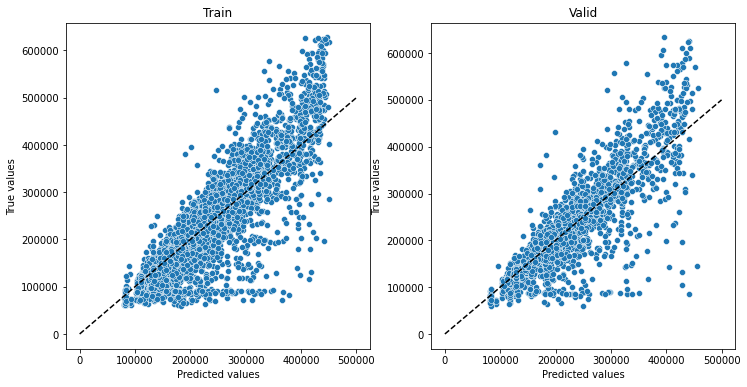

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(121)
evaluate_preds(y_train, y_train_preds)
plt.title('Train')
plt.subplot(122)
evaluate_preds(y_valid, y_valid_preds)
plt.title('Valid')
plt.show()

In [34]:
# test predict
X_test = X_test[feature_names]
y_test_preds = rf_model.predict(X_test)

# GridSearchCV

In [35]:
# params = [{
#     'n_estimators': [40, 60, 80], 
#     'max_features': [5, 8, 12], 
#     'max_depth': [20, 30, 40],
# }]

In [36]:
# clf = GridSearchCV(estimator=RandomForestRegressor(random_state=39), 
#                    param_grid=params,
#                    scoring='r2',
#                    cv=None
#                    )

In [37]:
# clf.fit(X_train, y_train)

In [38]:
# clf.best_params_

# Linear Regression model


In [39]:
scaler = StandardScaler()

In [40]:
X_train_lr = X_train.copy()
scaler.fit_transform(X_train_lr)

array([[ 0.13548134,  1.13357851,  0.05119382, ...,  1.51525172,
        -0.32585763,  1.73265725],
       [ 0.13548134, -0.43761385, -0.21553113, ..., -0.2135438 ,
        -0.57176949,  0.08796441],
       [ 0.13548134, -0.06159413, -0.13081481, ..., -0.62418135,
        -0.55875474,  0.32516424],
       ...,
       [ 0.13548134, -0.45658929,  0.608492  , ...,  0.02912394,
         0.5695381 ,  0.74335273],
       [-1.09776883, -0.81480963, -0.65877782, ..., -0.67821163,
        -0.37144402, -0.33220815],
       [ 1.36873151,  0.37418934,  0.74370917, ...,  0.3324063 ,
        -0.58246668,  0.32516424]])

In [41]:
X_valid_lr = X_valid.copy()
scaler.fit_transform(X_valid_lr)

array([[-1.07939027, -0.62429956,  0.48014195, ..., -0.48443672,
         1.21997227, -1.19461555],
       [-1.07939027, -0.95887657, -0.9353573 , ..., -0.67821624,
        -0.60079268,  0.88104936],
       [ 0.13934169, -0.61189584, -0.26235128, ...,  0.08370338,
        -0.57687104,  2.80469623],
       ...,
       [ 0.13934169, -0.41404043, -0.28673282, ..., -0.32356772,
        -0.54536689,  1.65856195],
       [ 0.13934169, -0.23488878, -0.18770826, ..., -0.69233847,
        -0.63992204, -1.02477616],
       [ 0.13934169, -0.37922112, -0.14234606, ..., -0.39524077,
        -0.58130814,  0.04799116]])

In [42]:
X_test_lr = X_test.copy()
scaler.fit_transform(X_test_lr)

array([[-1.12103881, -1.03561772, -1.08505801, ..., -0.60666524,
        -0.44716331,  0.70990307],
       [-1.12103881, -0.73515726,  0.46840271, ..., -0.56920885,
         1.18359897, -1.11096031],
       [ 0.11412956,  0.15225436, -0.18258652, ..., -0.26241644,
        -0.66358868, -1.22112606],
       ...,
       [-1.12103881, -1.20321504, -1.09109423, ..., -0.2641856 ,
        -0.43903069,  0.30387808],
       [-1.12103881, -0.94173079, -0.96011088, ..., -0.79852011,
        -0.6155052 ,  0.61982609],
       [ 0.11412956,  0.55453465, -0.09918569, ...,  0.55963017,
        -0.55122233,  0.20860881]])

In [43]:
lr_model = LinearRegression()

In [44]:
lr_model.fit(X_train_lr, y_train)

LinearRegression()

In [45]:
scaler.fit_transform(X_test)

array([[-1.12103881, -1.03561772, -1.08505801, ..., -0.60666524,
        -0.44716331,  0.70990307],
       [-1.12103881, -0.73515726,  0.46840271, ..., -0.56920885,
         1.18359897, -1.11096031],
       [ 0.11412956,  0.15225436, -0.18258652, ..., -0.26241644,
        -0.66358868, -1.22112606],
       ...,
       [-1.12103881, -1.20321504, -1.09109423, ..., -0.2641856 ,
        -0.43903069,  0.30387808],
       [-1.12103881, -0.94173079, -0.96011088, ..., -0.79852011,
        -0.6155052 ,  0.61982609],
       [ 0.11412956,  0.55453465, -0.09918569, ...,  0.55963017,
        -0.55122233,  0.20860881]])

# Linear Regression Prediction

R2:	0.68
RMSE:	52376.639
MSE:	2743312363.621


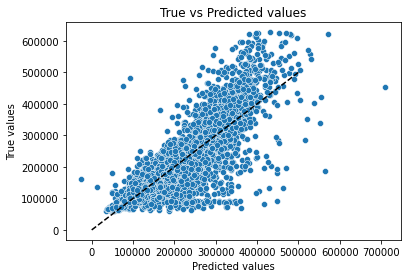

In [46]:
y_train_preds_lr = lr_model.predict(X_train_lr)
evaluate_preds(y_train, y_train_preds_lr)

R2:	0.662
RMSE:	54457.834
MSE:	2965655729.778


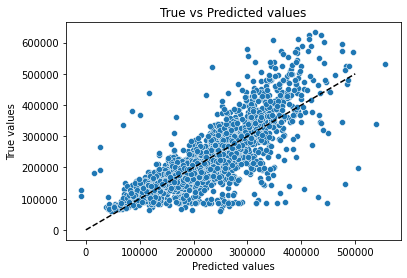

In [47]:
y_valid_preds_lr = lr_model.predict(X_valid_lr)
evaluate_preds(y_valid, y_valid_preds_lr)

# Save to csv

In [48]:
submit = pd.read_csv(PATH + SUBMITION_DATASET, sep=',')
submit.head(10)

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0
5,868,200000.0
6,672,200000.0
7,2471,200000.0
8,4510,200000.0
9,8354,200000.0


In [49]:
submit['Price'] = y_test_preds

In [50]:
submit.to_csv(SUBMITION_MY, index=False, encoding='utf-8', sep=',')
submit.head()

,Id,Price
0,4567,166704.812329
1,5925,122252.967902
2,960,151878.998853
3,3848,147376.923000
4,746,164471.956676
